In [1]:
## Import relevant packages
import numpy as np
import matplotlib.pyplot as plt
import pyOptimalEstimation as pyOE
import os
import sys
import re
import scipy.stats as stats
import seaborn as sns

## append paths
sys.path.append('C:/Users/Ida Olsen/Documents/Speciale_2022/scripts')
parrent_dir = "C:\\Users\\Ida Olsen\\Documents\\Speciale_2022"
sys.path.append(parrent_dir + '\\smrt')
sys.path.append(parrent_dir + '\\Ida_passive_SMRT\\Ida_passive_SMRT\\Code')

## Import SMRT packages
from smrt.permittivity.saline_snow import saline_snow_permittivity_scharien_with_stogryn95 as ssp
from smrt import make_ice_column, make_interface, make_snowpack, sensor_list
from smrt.core.globalconstants import PSU
from smrt import make_model
from smrt.interface.iem_fung92_brogioni10 import IEM_Fung92_Briogoni10
from smrt import SMRTError
from IPython.display import clear_output

## self made modules
from Snowpit_class import Snowpit_info
from roughness import roughness
from Make_plots import plot_freq
from forward_functions import forward_mean, forward_OIB
from prepare_inputs_OE import prepare_inputs, prepare_inputs_FYI
import prepare_inputs_OE as piO

In [2]:
def corrMat(self, data):
    ## Make correlation matrix - input covariance matrix
    corrMat = np.zeros(data.shape)
    sigmas = np.diag(data)**(1/2)
    rows = range(data.shape[0])
    cols = range(data.shape[1])
    for row in rows:
        sigma1 = sigmas[row]
        for col in cols:
            sigma2 = sigmas[col]

            corrMat[row][col] = np.array(data)[row][col]/(sigma1*sigma2)

    fig, ax = plt.subplots(figsize=(9, 6))
    im = ax.imshow(corrMat, cmap="inferno")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(data.keys())), labels=data.keys())
    ax.set_yticks(np.arange(len(data.keys())), labels=data.keys())

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    # Loop over data dimensions and create text annotations.
    for i in range(len(data.keys())):
        for j in range(len(data.keys())):
            if np.round(corrMat[i, j],2) > 0.5:
                text = ax.text(j, i, np.round(corrMat[i, j],2),
                       ha="center", va="center", color="k")
            else:
                text = ax.text(j, i, np.round(corrMat[i, j],2),
                               ha="center", va="center", color="w")

    ax.set_title(r'Output correlation matrix')
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)


    fig.tight_layout()
    plt.savefig(savepath + 'CorrOut.png' )
    plt.show()
    
def covMat(self, data, title):
    for var in self.x_vars:
        print(var)
        data[var][var] = data[var][var]**(1/2)
    ## get std
    try:
       data['lex']['lex'] = data['lex']['lex']*1e1
    except:
        pass
    try:
        data['sal']['sal'] = data['sal']['sal']*1e1
    except:
        pass
    try:
        data['Tsur']['Tsur'] = data['Tsur']['Tsur']/1e2
    except:
        pass
    try:
        data['rho']['rho'] = data['rho']['rho']/1e2
    except:
        pass
    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(
        data*1e2,
        annot=True, 
        fmt='.4f', 
        ax=ax, 
        linewidths=.05, 
        cbar_kws={'label':'Modified Covariance [cm,mm,PSU,kg/m3,K,cm,'']'}
    )
    ax.set_title(title)
    if 'out' in title:
        plt.savefig(savepath + 'CovOut.png' )
    else:
        plt.savefig(savepath + 'CovIn.png' )
    plt.show()
def makeOEobject(x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB):
    nl_snow = 2
    x_vars = list(x_upperLimit.keys())
    forwardKwArgs = {"variables": x_vars, "nl_snow": nl_snow, "n": 0, "pol":polarization
                     , "nls":1, "avg":True, "sim":True}
    oe = pyOE.optimalEstimation(
    x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB
    ,forwardKwArgs=forwardKwArgs
    ,x_lowerLimit=x_lowerLimit
    ,x_upperLimit=x_upperLimit
    )
    return oe
def calc_ang(var1, var2):
    
    text_file = open(savepath + "angles_jacobian.txt", "a")
    
    J = oe.getJacobian(oe.x_op, oe.y_op)[0]
    print('--------------------------------------------------')
    text_file.write('--------------------------------------------------\n')
    
    denominator = np.linalg.norm(J['perturbed '+var1][:5])*np.linalg.norm(J['perturbed '+var2][:5])
    nominator = np.dot(J['perturbed '+var1][:5], J['perturbed '+var2][:5])
    print('Angle between '+var1+' and '+var2+' vector V:', np.round(np.rad2deg(np.arccos(nominator/denominator)),2))
    text_file.write('Angle between '+var1+' and '+var2+' vector V:' + str(np.round(np.rad2deg(np.arccos(nominator/denominator)),2)) + '\n')

    
    denominator = np.linalg.norm(J['perturbed '+var1][5:])*np.linalg.norm(J['perturbed '+var2][5:])
    nominator = np.dot(J['perturbed '+var1][5:], J['perturbed '+var2][5:])
    print('Angle between '+var1+' and '+var2+ ' vector H:', np.round(np.rad2deg(np.arccos(nominator/denominator)),2))
    text_file.write('Angle between '+var1+' and '+var2+' vector H:' + str(np.round(np.rad2deg(np.arccos(nominator/denominator)),2)) + '\n')
def covOutMat(oe1, oe2):
    data=oe1/oe2
    f, ax = plt.subplots(figsize=(7, 7))
    sns.heatmap(
        data,
        cmap="rocket_r",
        annot=True, 
        fmt='.4f', 
        ax=ax, 
        linewidths=.08,
        cbar=False,
        cbar_kws={"shrink": 0.5, 'label':'Ratio of covariance compared to input'}
    )
    ax.set_title('Fraction of input variance')
    plt.savefig(savepath + 'CovRatioOuttoIn.png' )
    plt.show()

In [3]:
FYI_data = piO.OIB_data('FYI', new=False)

FYI_OIB_SIM = np.concatenate([np.mean(FYI_data.TbV_sim, axis=0), np.mean(FYI_data.TbH_sim, axis=0)])
FYI_OIB_AMSR = np.concatenate([np.mean(FYI_data.TbV_AMSR_all, axis=0), np.mean(FYI_data.TbH_AMSR_all, axis=0)])

FYI_OIB_AMSR_std = np.concatenate([np.std(FYI_data.TbV_AMSR_all, axis=0), np.std(FYI_data.TbH_AMSR_all, axis=0)])

## Make simulated data with noise
FYI_OIB_SIM_gaussian = FYI_OIB_SIM

### Choose looking at only V or at both

### Choose how many input variables 

### choose Sy sensitivity

In [5]:
# Saving location
# savepath = 'C:/Users/Ida Olsen/Documents/Speciale_2022/Results/Linear_tests' + '/Only V/Sy_test/SD_lex_sal_sit/'
#'SD_sit/small_y/'

# Polarization (V or both)
polarization = 'V'
# sensitivity of TBs (std)
V_sens = 0.3 # K
H_sens = 0.3 # K
# List with input variables
input_variables = ["SD", "SIT"]
x_vars=input_variables
## list with true values
x_truth = [np.mean(FYI_data.sd, axis=0)[0],
           #np.mean(FYI_data.sd_lex, axis=0)[0],
           #np.mean(FYI_data.sd_sal, axis=0)[0],
           #np.mean(FYI_data.sd_rho, axis=0)[0],
           # np.mean(FYI_data.skt),
           np.mean(FYI_data.sit)]
           #np.mean(FYI_data.OIB_surf_rough)]

In [6]:
x_cov = [[] for var in input_variables]
x_cov[0] = [sd[0] for sd in FYI_data.sd]
x_cov[1] = [sit for sit in FYI_data.sit]
XCOV = np.cov(x_cov)

In [7]:
## Define name of y-variables
if polarization=='both':
    y_vars = ["6V", "10V", "18V", "23V", "36V", "6H", "10H", "18H", "23H", "36H"]
    y_obs  = FYI_OIB_SIM_gaussian
    # y_cov = np.diag([V_sens**2]*5 + [H_sens**2]*5)
    y_cov = np.diag(np.array([0.3, 0.3, 0.6, 1.1, 1.1] + [0.3, 0.3, 0.6, 1.1, 1.1])**2)
    # y_cov = np.diag(np.array([0.1, 0.1, 0.1, 0.1, 0.1] + [0.1, 0.1, 0.1, 0.1, 0.1])**2)
elif polarization=='V':
    y_vars = ["6V", "10V", "18V", "23V", "36V"]
    y_obs = np.mean(FYI_data.TbV_sim, axis=0)
    y_cov = np.diag([V_sens**2]*5)
    y_cov = np.diag(np.array([0.3, 0.3, 0.6, 1.1, 1.1])**2)

# Define name of x-variable
x_vars = input_variables
## prepare first guess, covariance matrix, upper and lower limits
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = prepare_inputs_FYI(FYI_data, x_vars, logarithmic=False, sim=True, nls=1)

print(x_ap)
print('Guess in linear units', np.round(x_ap,2)[:3])

[0.08159524 0.00924204 0.18793142 0.03643294]
[0.08159524 0.00924204 0.18793142 0.03643294]
[0.08159524 0.00924204 0.18793142 0.03643294]
[0.08159524 0.00924204 0.18793142 0.03643294]
[0.10567324 1.43982817]
Guess in linear units [0.11 1.44]


Text(0.5, 1.0, 'Measurement uncertainty $\\mathbf{S}_{y}$')

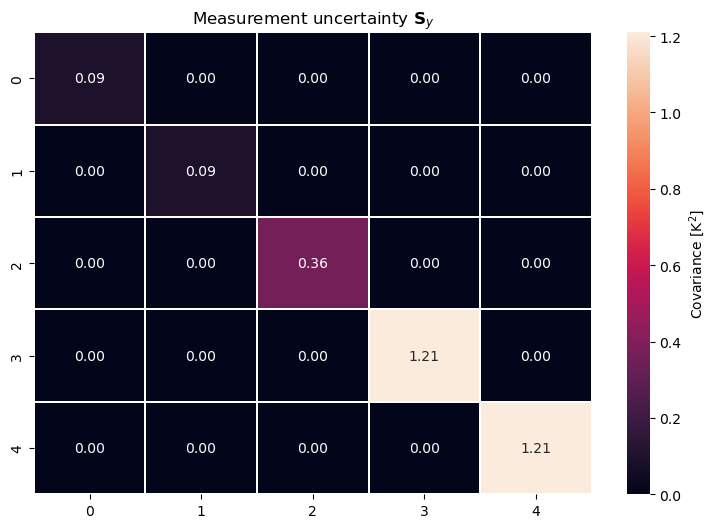

In [8]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(
    y_cov, 
    annot=True, 
    fmt='.2f', 
    ax=ax, 
    linewidths=.05, 
    cbar_kws={'label':'Covariance [K$^2$]'}
)
ax.set_title(r'Measurement uncertainty $\mathbf{S}_{y}$')

[0.08159524 0.00924204 0.18793142 0.03643294]
[0.08159524 0.00924204 0.18793142 0.03643294]
[0.08159524 0.00924204 0.18793142 0.03643294]
[0.08159524 0.00924204 0.18793142 0.03643294]
[[0.00229797 0.00532633]
 [0.00532633 0.09241524]]
SD
SIT


NameError: name 'savepath' is not defined

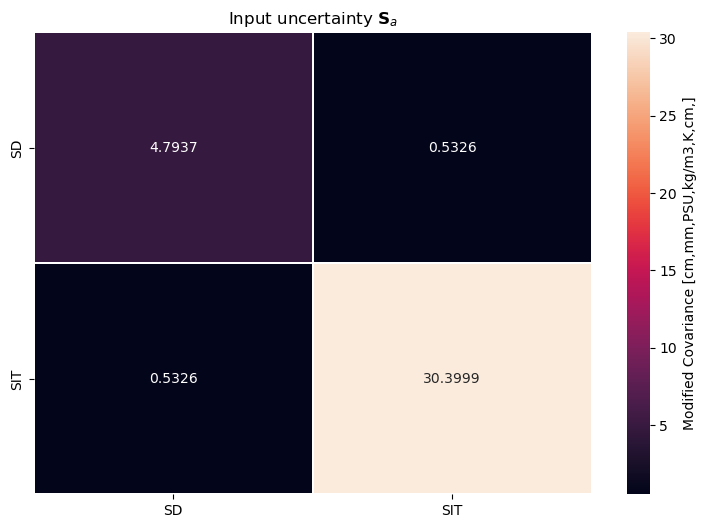

In [9]:
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = prepare_inputs_FYI(FYI_data,x_vars, logarithmic=False, sim=True, nls=1)
print(x_cov)
# diag = [(4.8e-2)**2, (0.028e-3)**2, (0.2637e-3)**2, (319.15e-2)**2, (30.0e-2)**2, (0.03)**2]
diag = [(4.8e-2)**2, (30.0e-2)**2]
x_cov = np.diag(diag)
x_cov = XCOV
# x_ap[-1]=0.08
# diag = [(4.8e-2)**2, (30.0e-2)**2]

try:
    float(x_cov)
    x_cov= np.array([[x_cov]])
except:
    pass
oe_show = makeOEobject(x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB)
title = r'Input uncertainty $\mathbf{S}_{a}$'
covMat(oe_show, oe_show.S_a, title)

print(x_ap)

[256.22667339 260.26182226]
261.1540723950472


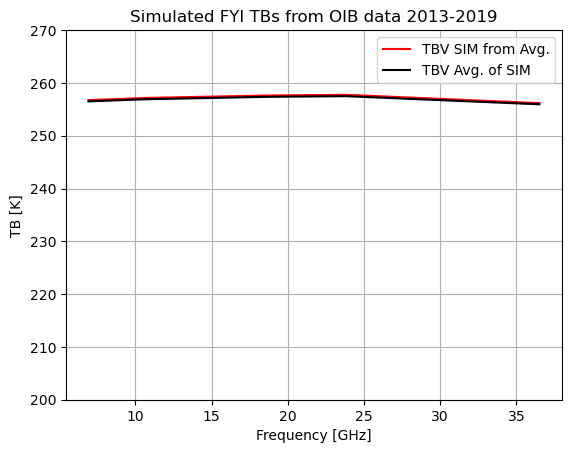

In [10]:
## Plots results
#plt.figure(figsize=(8,6))
frequencies=[6.925e9,10.65e9,18.7e9,23.8e9,36.5e9];
freqs = [f*1e-9 for f in frequencies]

data = forward_OIB(X=x_ap,self=FYI_data,variables=x_vars, nl_snow = 2, n=0, pol=polarization,
                   logarithmic=False, nls=1, avg=True, sim=True)

y = data[:5]
plt.plot(freqs, y, c='r',label = 'TBV SIM from Avg.')
#y = data[5:]
#plt.plot(freqs,y, c='b', label = 'TBH SIM from Avg.')
y = FYI_OIB_SIM[:5]
plt.plot(freqs, y, c='k', label = 'TBV Avg. of SIM')
#y = FYI_OIB_SIM[5:]
#plt.plot(freqs, y, c='green', label = 'TBH Avg. of SIM')
plt.grid()
plt.ylim([200,270])
plt.legend()
plt.xlabel('Frequency [GHz]')
plt.ylabel('TB [K]')
plt.title('Simulated FYI TBs from OIB data 2013-2019')
# plt.savefig(os.path.join(self.pp, 'OE_figures/Simulated_data.png'), bbox_inches='tight')
plt.show()

['SD', 'SIT']
[0.10567324 1.43982817]
[[0.04793711 0.00532633]
 [0.00532633 0.09241524]]
0.64 s, iteration 1, degrees of freedom: 0.98 of 2, converged (x-space):  0.001
0.93 s, iteration 2, degrees of freedom: 0.98 of 2, done.  0.000
-----------------
TRUE VALUES
-----------------
SD:  [0.10567324 0.03      ]
lex:  [0.14013647 0.16445789]
sal:  [0.88802032 8.67319838]
SIT:  1.4398281690140846
-----------------
SD     0.097953
SIT    1.440457
dtype: float64
SD    9.795273
dtype: float64
SIT    1440.457469
dtype: float64
-----------------
Jacobian matrix:
      perturbed SD  perturbed SIT
6V      30.064483      -2.736162
10V     30.962401      -2.720854
18V     30.398863      -2.728035
23V     28.881966      -2.674123
36V     25.005260      -2.664620


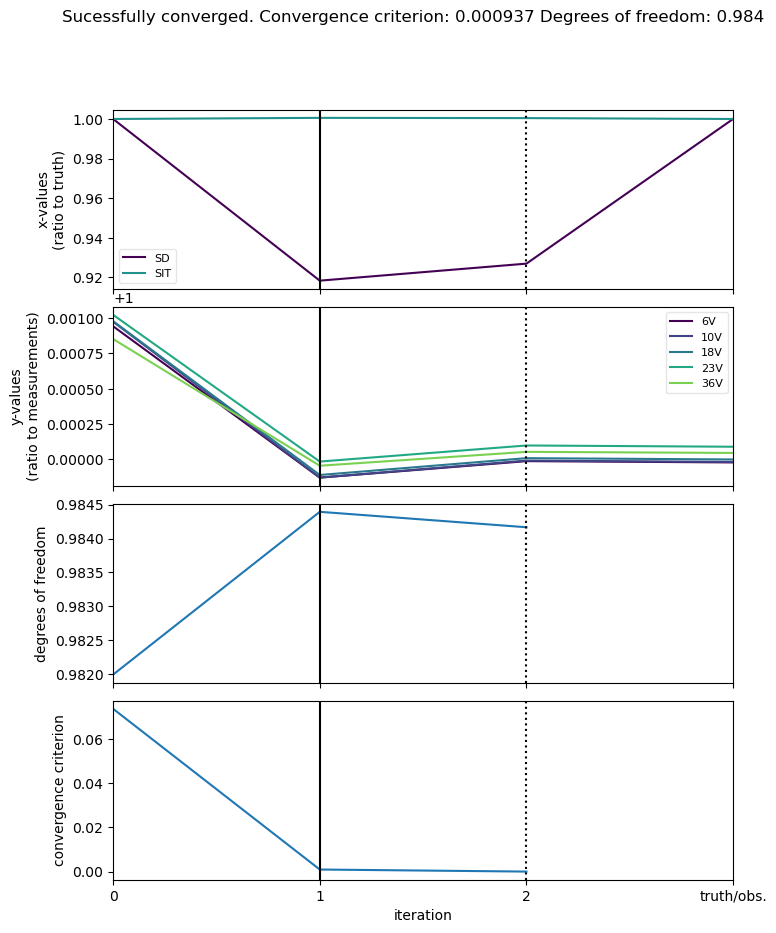

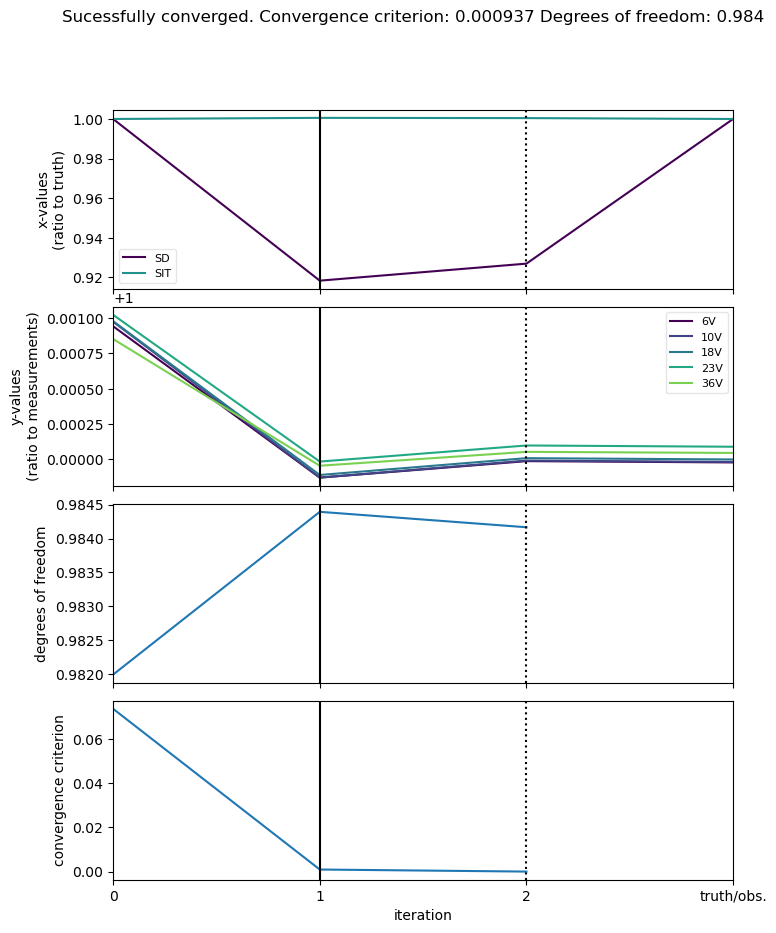

In [87]:
## Iterate over different start guesses

## scale covariance ? and convert to diagonal
try:
    d = np.diag(x_cov)
    x_cov = np.diag(d)
except:
    print('One dimensional marix')
    x_cov = np.array([[x_cov]])

diag = [(4.8e-2)**2, (30.0e-2)**2]
x_cov = np.diag(diag)
x_cov = XCOV
# x_ap[0]=0.15

## define extra arguments to forward function
nl_snow=2
x_vars = list(x_upperLimit.keys())
print(x_vars)
print(x_ap)
print(x_cov)
forwardKwArgs = {"self":FYI_data,"variables": x_vars, "nl_snow": nl_snow, "n": 0, "pol":polarization
                 , "logarithmic": False, "nls":1, "avg":True, "sim":True}
# define the optimal estimation
oe = pyOE.optimalEstimation(
        x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB
        ,forwardKwArgs=forwardKwArgs
        ,x_lowerLimit=x_lowerLimit
        ,x_upperLimit=x_upperLimit
        ,x_truth=x_truth
        ,convergenceFactor=10
        )
# run the optimization and print outputs
oe.doRetrieval(maxIter=8)
print('-----------------')
print('TRUE VALUES')
print('-----------------')
print('SD: ', np.mean(FYI_data.sd, axis=0))
print('lex: ',np.mean(FYI_data.sd_lex, axis=0)*1e3)
print('sal: ',np.mean(FYI_data.sd_sal, axis=0)*1e3)
print('SIT: ',np.mean(FYI_data.sit))

print('-----------------')
print(oe.x_op)
print((oe.x_op[:1])*1e2)
try:
    print((oe.x_op[1:3])*1e3)
except:
    pass
# print((oe.x_op[3:]))
print('-----------------')
print('Jacobian matrix:\n', oe.getJacobian(oe.x_op, oe.y_op)[0])
oe.plotIterations()

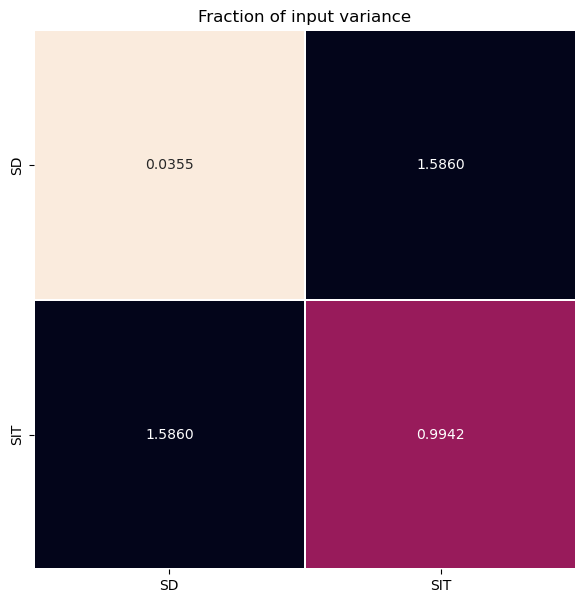

In [88]:
oe_show = makeOEobject(x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB)
covOutMat(oe.S_op, oe_show.S_a)

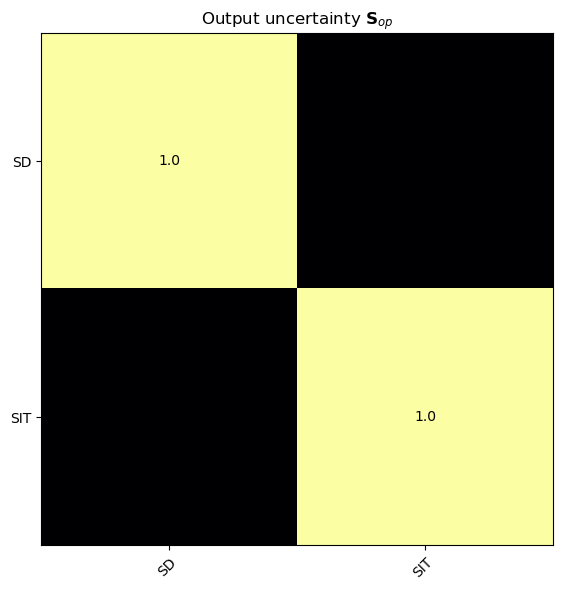

In [11]:
#def corrMat(data):
corrMat = np.zeros(oe.S_op.shape)
sigmas = np.diag(oe.S_op)**(1/2)
rows = range(oe.S_op.shape[0])
cols = range(oe.S_op.shape[1])
for row in rows:
    sigma1 = sigmas[row]
    for col in cols:
        sigma2 = sigmas[col]

        corrMat[row][col] = np.array(oe.S_op)[row][col]/(sigma1*sigma2)




fig, ax = plt.subplots(figsize=(9, 6))
im = ax.imshow(corrMat, cmap="inferno")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(oe.S_op.keys())), labels=oe.S_op.keys())
ax.set_yticks(np.arange(len(oe.S_op.keys())), labels=oe.S_op.keys())

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


# Loop over data dimensions and create text annotations.
for i in range(len(oe.S_op.keys())):
    for j in range(len(oe.S_op.keys())):
        if np.round(corrMat[i, j],2) > 0.5:
            text = ax.text(j, i, np.round(corrMat[i, j],2),
                   ha="center", va="center", color="k")
        else:
            text = ax.text(j, i, np.round(corrMat[i, j],2),
                           ha="center", va="center", color="w")

ax.set_title(r'Output uncertainty $\mathbf{S}_{op}$')
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)


fig.tight_layout()
# plt.savefig(savepath + str(slope_std) + '_CorrMatrixOut.png' )
plt.show()


In [12]:
## calculate angles if we have more than 1 input variable
text_file = open(savepath + "angles_jacobian.txt", "w")
if len(input_variables)>1:
    for i in range(len(input_variables)):
        for j in range(len(input_variables)):
            if i!=j:
                calc_ang(input_variables[i], input_variables[j])

NameError: name 'savepath' is not defined

### Test for assumptions

In [13]:
linearity, trueLinearityChi2, trueLinearityChi2Crit = oe.linearityTest(significance=0.05)
print('Linearity test passed: ', trueLinearityChi2 < trueLinearityChi2Crit)
chiSquareTest = oe.chiSquareTest(significance=0.05)
print('\nTests passed:\n' ,chiSquareTest[0])

Linearity test passed:  True
Warning. Singular Matrix with rank 2 instead of 5. (This is typically save to ignore)       

Tests passed:
 chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool


[0.08159524 0.00924204 0.18793142 0.03643294]
[0.08159524 0.00924204 0.18793142 0.03643294]
[0.08159524 0.00924204 0.18793142 0.03643294]
[0.08159524 0.00924204 0.18793142 0.03643294]
[[0.00229797 0.00532633]
 [0.00532633 0.09241524]]
1.09 s, iteration 1, degrees of freedom: 0.99 of 2, converged (x-space):  0.024
1.39 s, iteration 2, degrees of freedom: 0.98 of 2, done.  0.000
0.72 s, iteration 1, degrees of freedom: 0.98 of 2, converged (x-space):  0.001
1.00 s, iteration 2, degrees of freedom: 0.98 of 2, done.  0.000
0.68 s, iteration 1, degrees of freedom: 0.98 of 2, converged (x-space):  0.000
1.00 s, iteration 2, degrees of freedom: 0.98 of 2, done.  0.000
0.70 s, iteration 1, degrees of freedom: 0.98 of 2, converged (x-space):  0.000
1.02 s, iteration 2, degrees of freedom: 0.98 of 2, done.  0.000
0.73 s, iteration 1, degrees of freedom: 0.98 of 2, converged (x-space):  0.007
1.03 s, iteration 2, degrees of freedom: 0.98 of 2, done.  0.000
0.71 s, iteration 1, degrees of freedom:

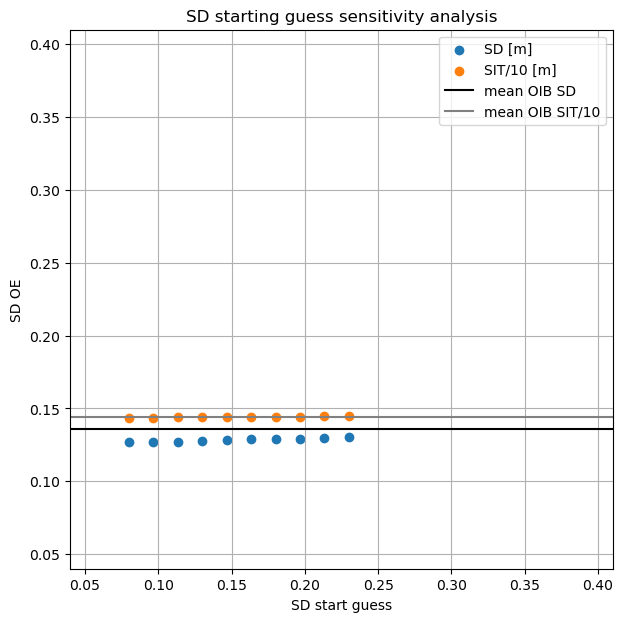

[0.08159524 0.00924204 0.18793142 0.03643294]
[0.08159524 0.00924204 0.18793142 0.03643294]
[0.08159524 0.00924204 0.18793142 0.03643294]
[0.08159524 0.00924204 0.18793142 0.03643294]
[[0.00229797 0.00532633]
 [0.00532633 0.09241524]]
############################################################
reset due to x_lowerLimit: SD from -0.045658 to 0.105673 in iteration 0
0.68 s, iteration 1, degrees of freedom: 1.04 of 2, not converged (x-space):  1.492
############################################################
reset due to x_lowerLimit: SD from -0.091633 to 0.105673 in iteration 2
0.99 s, iteration 2, degrees of freedom: 1.08 of 2, not converged (x-space):  4.615
1.30 s, iteration 3, degrees of freedom: 1.00 of 2, not converged (x-space):  7.043
############################################################
reset due to x_lowerLimit: SD from -0.051396 to 0.105673 in iteration 4
1.60 s, iteration 4, degrees of freedom: 1.09 of 2, not converged (x-space):  1.290
1.92 s, iteration 5, degrees o

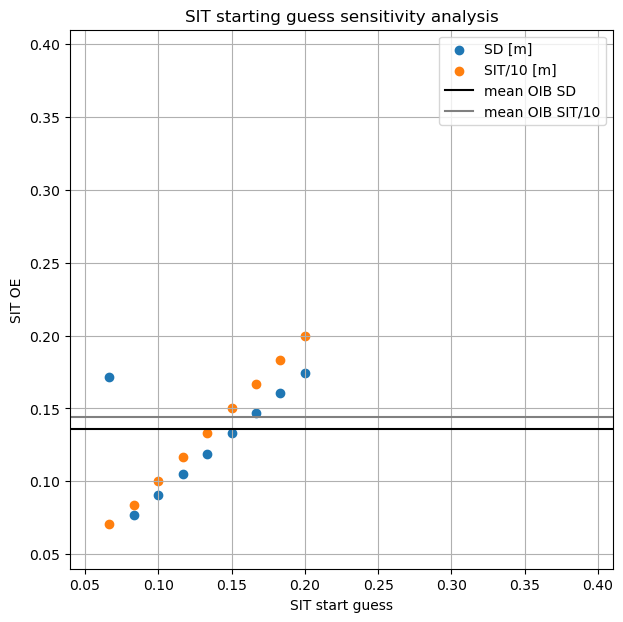

In [89]:
## Iterate over different start guesses (of SD)
savepath = "C:/Users/Ida Olsen/Documents/Speciale_2022/figures/reference_results/"
input_variables = x_vars
logarithmic=False
for var in input_variables:
    [x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = prepare_inputs_FYI(FYI_data,x_vars, logarithmic=False, sim=True, nls=1)
    print(x_cov)
    diag = [(4.8e-2)**2, (30.0e-2)**2]
    x_cov = np.diag(diag)
    x_cov = XCOV
    

    cc = []
    x_op = []
    ind = [i==var for i in input_variables]
    if var=='SD':
        if logarithmic==True:
            V0 = np.linspace(np.log10(0.08), np.log10(0.25), 10)
        else:
            V0 = np.linspace(0.05, 0.20, 10)
    elif var=='lex':
        if logarithmic==True:
            V0 =  np.linspace(np.log10(0.2*1e-3), np.log10(0.4*1e-3), 10)
        else:
            V0 =  np.linspace(0.1*1e-3, 0.3*1e-3, 10)
    elif var=='sal':
        V0 =  np.linspace(2*PSU, 10*PSU, 10)
        # V0 =  np.linspace(np.log10(0.1*PSU), np.log10(2*PSU), 10)
    elif var=='rho':
        V0 = np.linspace(200, 400, 10)
    elif var=='Tsur':
        V0 = np.linspace(249, 256, 10)
    elif var=='SIT':
        V0 = np.linspace(0.5, 2.0, 10)
    elif var=='slope':
        V0 = np.linspace(0.02, 0.2, 10)

    for v0 in V0:
        x_ap[ind] =v0
        ## define extra arguments to forward function
        forwardKwArgs = {"self":FYI_data,"variables": x_vars, "nl_snow": nl_snow, "n": 0, "pol":polarization
                         , "logarithmic": False, "nls":1, "avg":True, "sim":True}
        # define the optimal estimation
        oe = pyOE.optimalEstimation(
                x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB
                ,forwardKwArgs=forwardKwArgs
                ,x_lowerLimit=x_lowerLimit
                ,x_upperLimit=x_upperLimit
                ,x_truth=x_truth
                ,convergenceFactor=10
                )

        try:
            # run the optimization and print outputs
            oe.doRetrieval(maxIter=6)
            oe.plotIterations
            cc.append(oe.S_op)
            x_op.append(oe.x_op)
        except:
            print('NC')
            V0 = np.delete(V0, [np.where(V0==v0)])
        
    ## Plot results
    plt.figure(figsize=(7,7))
    # print(var)
    for i in range(len(input_variables)):
        print(i)
        
        if input_variables[i]!="SIT" and input_variables[i]!="rho" and input_variables[i]!="sal" and input_variables[i]!="slope" and logarithmic==True:
            V = [10**x[input_variables[i]] for x in x_op if ~np.isnan(x).any()]
        else:
            V = [x[input_variables[i]] for x in x_op if ~np.isnan(x).any()]
        if var!="SIT" and var!="rho" and var!="sal" and var!='slope' and logarithmic==True:
            VV0 = [10**v0 for v0,x in zip(V0, x_op) if ~np.isnan(x).any()]
        else:
            VV0 = [v0 for v0,x in zip(V0, x_op) if ~np.isnan(x).any()]
        if input_variables[i]=="lex" or input_variables[i]=="sal":
            V = np.array(V)*1e3
        if var=="lex" or var=="sal":
            VV0 = np.array(VV0)*1e3
        if var=="sal":
            VV0 = VV0/50
            print(VV0)
        if var=="SD":
            VV0 = np.array(VV0)+0.03
            print(VV0)
        if input_variables[i]=="sal":
            V=V/50
            label = "sal/50 [PSU]"
        if input_variables[i]=="lex":
            label = "lex [mm]"
        if input_variables[i]=="SD":
            V=np.array(V)+0.03
            print(V)
            label = "SD [m]"
        if var=='rho' or var=='Tsur':
            VV0 = np.array(VV0)/1000
        if input_variables[i]=="rho":
            V = np.array(V)/1000
            label = "rho [g/cm3]"
        if input_variables[i]=="Tsur":
            V = np.array(V)/1000
            label = "Tsur/1000 [K]"
        if var=="SIT":
            VV0 = np.array(VV0)/10
        if input_variables[i]=="SIT":
            V=np.array(V)/10
            label = "SIT/10 [m]"
        if input_variables[i]=="slope":
            # V=np.array(V)/10
            label = "roughness"
        # print(VV0)
        # print(V)
        plt.scatter(VV0, V, label=label)#input_variables[i])
    print(np.mean(10**FYI_data.sd))
    plt.xlabel(var + ' start guess')
    plt.ylabel(var +' OE')
    if logarithmic==True:
        plt.axhline(np.mean(10**FYI_data.sd), color='k', label='mean OIB SD')
    else:
        plt.axhline(np.mean(np.sum(FYI_data.sd, axis=1)), color='k', label='mean OIB SD')
    plt.axhline(np.mean(FYI_data.sit)/10, color='grey', label='mean OIB SIT/10')
    if "Tsur" in var:
        plt.xlim([0.2, 0.3])
        #plt.ylim([0.04, 0.41])
    else:
        plt.xlim([0.04, 0.41])
    plt.ylim([0.04, 0.41])
    plt.legend()
    plt.grid()
    plt.title(var + ' starting guess sensitivity analysis')
    # plt.savefig(savepath + var + 'V'+'.png' )
    plt.show()

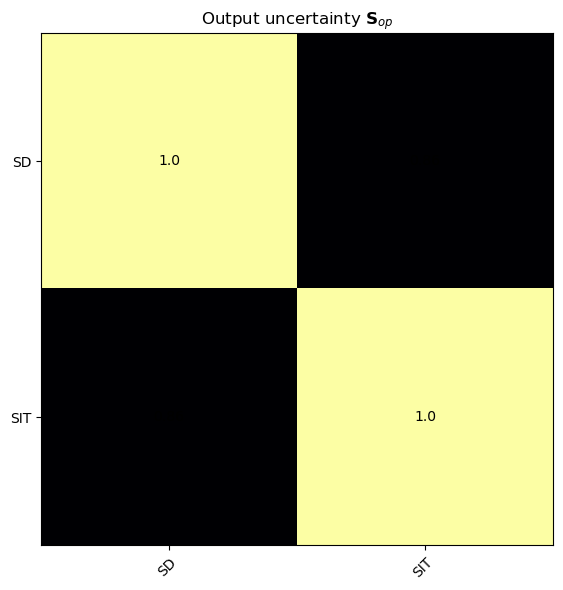

In [15]:
#def corrMat(data):
corrMat = np.zeros(oe.S_op.shape)
sigmas = np.diag(oe.S_op)**(1/2)
rows = range(oe.S_op.shape[0])
cols = range(oe.S_op.shape[1])
for row in rows:
    sigma1 = sigmas[row]
    for col in cols:
        sigma2 = sigmas[col]
        
        corrMat[row][col] = np.array(oe.S_op)[row][col]/(sigma1*sigma2)

        
        
 
fig, ax = plt.subplots(figsize=(9, 6))
im = ax.imshow(corrMat, cmap="inferno")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(oe.S_op.keys())), labels=oe.S_op.keys())
ax.set_yticks(np.arange(len(oe.S_op.keys())), labels=oe.S_op.keys())

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


# Loop over data dimensions and create text annotations.
for i in range(len(oe.S_op.keys())):
    for j in range(len(oe.S_op.keys())):
        if np.round(corrMat[i, j],2) > 0.5:
            text = ax.text(j, i, np.round(corrMat[i, j],2),
                   ha="center", va="center", color="k")
        else:
            text = ax.text(j, i, np.round(corrMat[i, j],2),
                           ha="center", va="center", color="w")

ax.set_title(r'Output uncertainty $\mathbf{S}_{op}$')
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)


fig.tight_layout()
plt.savefig(savepath + 'CorrMatrixOut.png' )
plt.show()

In [18]:
print(np.std(np.sum(FYI_data.sd,axis=1)))
print(np.std(FYI_data.sit))

0.047869543840883
0.3035702787429693


In [43]:
y_cov

array([[0.04, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.04, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.04, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.04, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.04]])

In [96]:
# ns = 200
y_cov = np.diag(np.array([0.2]*5)**2)

ns = len(FYI_data.skt)

[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = prepare_inputs_FYI(FYI_data,x_vars, logarithmic=False, sim=True, nls=1)
diag = [np.var(np.sum(FYI_data.sd,axis=1)),  np.var(FYI_data.sit)]
x_cov = np.diag(diag)
x_cov = XCOV

#try:
#    d = np.diag(x_cov)
#    x_cov = np.diag(d)
#except:
#    print('One dimensional marix')
#    x_cov = np.array([[x_cov]])

def do_OE_sim(ns, noise=False):
    if polarization=='both':
        data=zip(FYI_data.TbV_sim[:ns], FYI_data.TbH_sim[:ns])
    elif polarization=='V':
        data=FYI_data.TbV_sim[:ns]
    results = []
    x_optimals = []
    nn = [i for i in range(ns)]
    no = []
    for Tb, n in zip(data, range(len(FYI_data.skt[:ns]))):
        print('Point number: ', n)
        forwardKwArgs = {"self":FYI_data, "variables": x_vars, "nl_snow": 2, "n": n, "pol":polarization
                         , "logarithmic": False, "nls":1, "avg":False, "sim":True}
        # define the optimal estimation
        y_obs = np.array(Tb).flatten()
        # print(y_obs)
        oe = pyOE.optimalEstimation(
                x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB
                ,forwardKwArgs=forwardKwArgs
                ,x_lowerLimit=x_lowerLimit
                ,x_upperLimit=x_upperLimit
                ,convergenceFactor=10
                )
        try:
            oe.doRetrieval(maxIter=5)
            x_optimals.append(oe.x_op)
            results.append(oe.y_op)
        except:
            print('Convergence not reached')
            nn.remove(n)
            no.append(n)
    return [nn, no, x_optimals, results]

[nn, no, x_optimals, results] = do_OE_sim(ns)

[0.08159524 0.00924204 0.18793142 0.03643294]
[0.08159524 0.00924204 0.18793142 0.03643294]
[0.08159524 0.00924204 0.18793142 0.03643294]
[0.08159524 0.00924204 0.18793142 0.03643294]
Point number:  0
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.70 s, iteration 1, degrees of freedom: 1.15 of 2, not converged (x-space):  15.227
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.99 s, iteration 2, degrees of freedom: 1.18 of 2, converged (x-space):  0.059
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.33 s, iteration 3, degrees of freedom: 1.18 of 2, done.  0.000
Point number:  1
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unk

using real values for unknowns
using real values for unknowns
1.44 s, iteration 3, degrees of freedom: 1.30 of 2, done.  0.000
Point number:  13
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.75 s, iteration 1, degrees of freedom: 1.35 of 2, not converged (x-space):  0.489
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.08 s, iteration 2, degrees of freedom: 1.36 of 2, converged (x-space):  0.001
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.38 s, iteration 3, degrees of freedom: 1.36 of 2, done.  0.000
Point number:  14
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values f

1.48 s, iteration 3, degrees of freedom: 1.41 of 2, done.  0.001
Point number:  25
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.80 s, iteration 1, degrees of freedom: 1.52 of 2, not converged (x-space):  1.821
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.15 s, iteration 2, degrees of freedom: 1.50 of 2, converged (x-space):  0.091
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.50 s, iteration 3, degrees of freedom: 1.50 of 2, done.  0.000
Point number:  26
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.81 s, iteration 1, degrees of freedom: 1.55 of 2

using real values for unknowns
1.46 s, iteration 3, degrees of freedom: 1.26 of 2, done.  0.000
Point number:  38
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.80 s, iteration 1, degrees of freedom: 1.24 of 2, not converged (x-space):  3.198
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.15 s, iteration 2, degrees of freedom: 1.25 of 2, converged (x-space):  0.007
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.47 s, iteration 3, degrees of freedom: 1.25 of 2, done.  0.000
Point number:  39
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.80 s, iteration 1

using real values for unknowns
using real values for unknowns
1.15 s, iteration 2, degrees of freedom: 1.21 of 2, converged (x-space):  0.074
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.51 s, iteration 3, degrees of freedom: 1.21 of 2, done.  0.001
Point number:  51
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.77 s, iteration 1, degrees of freedom: 1.15 of 2, not converged (x-space):  22.684
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.12 s, iteration 2, degrees of freedom: 1.18 of 2, converged (x-space):  0.106
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.46 s, iteration 3, degrees of freedom: 1.18 of 2, done.  0.001
Point number:  52
using real values for unknowns


0.80 s, iteration 1, degrees of freedom: 1.30 of 2, converged (x-space):  0.007
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.15 s, iteration 2, degrees of freedom: 1.30 of 2, done.  0.000
Point number:  63
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.79 s, iteration 1, degrees of freedom: 1.34 of 2, not converged (x-space):  0.502
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.13 s, iteration 2, degrees of freedom: 1.34 of 2, converged (x-space):  0.000
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.48 s, iteration 3, degrees of freedom: 1.34 of 2, done.  0.000
Point number:  64
using real values for unknowns
using real values for unknowns
using real values for unknowns
u

1.13 s, iteration 2, degrees of freedom: 1.18 of 2, converged (x-space):  0.042
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.46 s, iteration 3, degrees of freedom: 1.18 of 2, done.  0.000
Point number:  77
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.81 s, iteration 1, degrees of freedom: 1.15 of 2, not converged (x-space):  16.879
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.23 s, iteration 2, degrees of freedom: 1.18 of 2, converged (x-space):  0.054
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.64 s, iteration 3, degrees of freedom: 1.18 of 2, done.  0.000
Point number:  78
using real values for unknowns
using real values for unknowns
using real values for unknowns


1.27 s, iteration 2, degrees of freedom: 1.31 of 2, converged (x-space):  0.002
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.62 s, iteration 3, degrees of freedom: 1.31 of 2, done.  0.000
Point number:  91
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.80 s, iteration 1, degrees of freedom: 1.35 of 2, converged (x-space):  0.024
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.14 s, iteration 2, degrees of freedom: 1.35 of 2, done.  0.000
Point number:  92
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.75 s, iteration 1, degrees of freedom: 1.19 of 2, no

using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.80 s, iteration 1, degrees of freedom: 1.30 of 2, converged (x-space):  0.002
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.13 s, iteration 2, degrees of freedom: 1.29 of 2, done.  0.000
Point number:  106
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.82 s, iteration 1, degrees of freedom: 1.16 of 2, not converged (x-space):  0.428
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.17 s, iteration 2, degrees of freedom: 1.16 of 2, converged (x-space):  0.002
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.52 s, iteration 3, degrees of freedom: 1.16 of 2, 

using real values for unknowns
using real values for unknowns
1.50 s, iteration 3, degrees of freedom: 1.13 of 2, converged (x-space):  0.011
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.84 s, iteration 4, degrees of freedom: 1.13 of 2, done.  0.000
Point number:  121
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.80 s, iteration 1, degrees of freedom: 1.43 of 2, converged (x-space):  0.094
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.15 s, iteration 2, degrees of freedom: 1.52 of 2, done.  0.008
Point number:  122
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for

using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.77 s, iteration 1, degrees of freedom: 1.27 of 2, not converged (x-space):  5.514
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.12 s, iteration 2, degrees of freedom: 1.34 of 2, converged (x-space):  0.031
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.46 s, iteration 3, degrees of freedom: 1.33 of 2, done.  0.002
Point number:  134
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.81 s, iteration 1, degrees of freedom: 1.22 of 2, not converged (x-space):  8.458
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.14 s, iteration 2, degrees of freedom: 1.29 of

using real values for unknowns
using real values for unknowns
1.83 s, iteration 4, degrees of freedom: 1.11 of 2, done.  0.000
Point number:  145
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.79 s, iteration 1, degrees of freedom: 1.05 of 2, not converged (x-space):  197.739
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.16 s, iteration 2, degrees of freedom: 1.10 of 2, not converged (x-space):  3.708
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.51 s, iteration 3, degrees of freedom: 1.10 of 2, converged (x-space):  0.036
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.83 s, iteration 4, degrees of freedom: 1.10 of 2, done.  0.000
Point number:  146
using real values for un

using real values for unknowns
using real values for unknowns
1.54 s, iteration 3, degrees of freedom: 1.18 of 2, done.  0.000
Point number:  158
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.78 s, iteration 1, degrees of freedom: 1.16 of 2, not converged (x-space):  12.340
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.11 s, iteration 2, degrees of freedom: 1.19 of 2, converged (x-space):  0.047
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.44 s, iteration 3, degrees of freedom: 1.18 of 2, done.  0.000
Point number:  159
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real value

using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.79 s, iteration 1, degrees of freedom: 1.11 of 2, not converged (x-space):  9.538
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.13 s, iteration 2, degrees of freedom: 1.16 of 2, converged (x-space):  0.132
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.47 s, iteration 3, degrees of freedom: 1.16 of 2, done.  0.001
Point number:  171
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.79 s, iteration 1, degrees of freedom: 1.15 of 2, not converged (x-space):  4.178
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.13 s, iteration 2, degrees of freedom: 1.22 of

using real values for unknowns
using real values for unknowns
0.78 s, iteration 1, degrees of freedom: 1.88 of 2, not converged (x-space):  316.522
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.13 s, iteration 2, degrees of freedom: 1.27 of 2, not converged (x-space):  737.554
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.46 s, iteration 3, degrees of freedom: 1.06 of 2, not converged (x-space):  194.798
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.80 s, iteration 4, degrees of freedom: 1.10 of 2, not converged (x-space):  1.721
Point number:  182
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
############################################################
reset due to x_lowerLimit: SD from -0.002402 to 0.105673 in iteration 0
using real values for unknowns
using real

using real values for unknowns
1.11 s, iteration 2, degrees of freedom: 1.25 of 2, converged (x-space):  0.017
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.46 s, iteration 3, degrees of freedom: 1.24 of 2, done.  0.000
Point number:  193
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.80 s, iteration 1, degrees of freedom: 1.16 of 2, not converged (x-space):  23.250
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.15 s, iteration 2, degrees of freedom: 1.20 of 2, converged (x-space):  0.070
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.48 s, iteration 3, degrees of freedom: 1.20 of 2, done.  0.001
Point number:  194
using real values for unknowns
using real values for unknown

using real values for unknowns
using real values for unknowns
using real values for unknowns
0.78 s, iteration 1, degrees of freedom: 1.21 of 2, not converged (x-space):  1.863
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.13 s, iteration 2, degrees of freedom: 1.22 of 2, converged (x-space):  0.009
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.46 s, iteration 3, degrees of freedom: 1.22 of 2, done.  0.000
Point number:  206
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.77 s, iteration 1, degrees of freedom: 1.07 of 2, converged (x-space):  0.029
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.10 s, iteration 2, degrees of freedom: 1.07 of 2, done.  0.000
Point number:  207

using real values for unknowns
using real values for unknowns
using real values for unknowns
0.77 s, iteration 1, degrees of freedom: 1.04 of 2, converged (x-space):  0.006
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.13 s, iteration 2, degrees of freedom: 1.04 of 2, done.  0.000
Point number:  220
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.80 s, iteration 1, degrees of freedom: 1.51 of 2, converged (x-space):  0.035
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.11 s, iteration 2, degrees of freedom: 1.48 of 2, done.  0.003
Point number:  221
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for

using real values for unknowns
using real values for unknowns
1.08 s, iteration 2, degrees of freedom: 1.40 of 2, done.  0.000
Point number:  234
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.71 s, iteration 1, degrees of freedom: 1.39 of 2, converged (x-space):  0.013
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.03 s, iteration 2, degrees of freedom: 1.39 of 2, done.  0.000
Point number:  235
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.75 s, iteration 1, degrees of freedom: 1.36 of 2, converged (x-space):  0.012
using real values for unknowns
using real values for unknowns
using real values for

using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.71 s, iteration 1, degrees of freedom: 1.31 of 2, converged (x-space):  0.033
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.02 s, iteration 2, degrees of freedom: 1.31 of 2, done.  0.001
Point number:  251
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.74 s, iteration 1, degrees of freedom: 1.40 of 2, not converged (x-space):  0.252
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.05 s, iteration 2, degrees of freedom: 1.41 of 2, converged (x-space):  0.001
using real values for unknowns
using real values for unknowns
using real values for

using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.77 s, iteration 1, degrees of freedom: 1.33 of 2, converged (x-space):  0.014
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.08 s, iteration 2, degrees of freedom: 1.33 of 2, done.  0.000
Point number:  264
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.73 s, iteration 1, degrees of freedom: 1.32 of 2, converged (x-space):  0.023
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.05 s, iteration 2, degrees of freedom: 1.32 of 2, done.  0.000
Point number:  265
using real values for unknowns
using real values for unknowns
using real values for

using real values for unknowns
using real values for unknowns
0.97 s, iteration 1, degrees of freedom: 1.44 of 2, not converged (x-space):  0.587
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.30 s, iteration 2, degrees of freedom: 1.45 of 2, converged (x-space):  0.002
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.62 s, iteration 3, degrees of freedom: 1.45 of 2, done.  0.000
Point number:  280
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.70 s, iteration 1, degrees of freedom: 1.53 of 2, not converged (x-space):  5.114
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.03 s, iteration 2, degrees of freedom: 1.51 of 2, converged (x-space):  0.007
using real values for unknowns

using real values for unknowns
1.33 s, iteration 3, degrees of freedom: 1.42 of 2, converged (x-space):  0.004
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.66 s, iteration 4, degrees of freedom: 1.42 of 2, done.  0.000
Point number:  293
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.71 s, iteration 1, degrees of freedom: 1.45 of 2, not converged (x-space):  1.388
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.00 s, iteration 2, degrees of freedom: 1.47 of 2, converged (x-space):  0.002
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.31 s, iteration 3, degrees of freedom: 1.47 of 2, done.  0.000
Point number:  294
using real values for unknowns
using real values for unknowns

using real values for unknowns
using real values for unknowns
using real values for unknowns
0.71 s, iteration 1, degrees of freedom: 1.61 of 2, not converged (x-space):  14.797
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.04 s, iteration 2, degrees of freedom: 1.66 of 2, converged (x-space):  0.023
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.31 s, iteration 3, degrees of freedom: 1.66 of 2, done.  0.001
Point number:  306
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.77 s, iteration 1, degrees of freedom: 1.55 of 2, not converged (x-space):  23.613
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.09 s, iteration 2, degrees of freedom: 1.95 of 2, not converged (x-space): 

using real values for unknowns
0.75 s, iteration 1, degrees of freedom: 1.54 of 2, not converged (x-space):  16.018
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.08 s, iteration 2, degrees of freedom: 1.43 of 2, not converged (x-space):  2.694
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.40 s, iteration 3, degrees of freedom: 1.39 of 2, converged (x-space):  0.008
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.71 s, iteration 4, degrees of freedom: 1.39 of 2, done.  0.000
Point number:  318
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.78 s, iteration 1, degrees of freedom: 1.45 of 2, not converged (x-space):  1.748
using real values for unknowns
using real values for unk

using real values for unknowns
1.43 s, iteration 3, degrees of freedom: 1.48 of 2, done.  0.000
Point number:  331
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.78 s, iteration 1, degrees of freedom: 1.51 of 2, not converged (x-space):  3.023
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.11 s, iteration 2, degrees of freedom: 1.54 of 2, converged (x-space):  0.004
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.45 s, iteration 3, degrees of freedom: 1.54 of 2, done.  0.000
Point number:  332
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.77 s, iteration

using real values for unknowns
0.79 s, iteration 1, degrees of freedom: 1.66 of 2, not converged (x-space):  5.859
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.13 s, iteration 2, degrees of freedom: 1.84 of 2, converged (x-space):  0.154
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.48 s, iteration 3, degrees of freedom: 1.80 of 2, done.  0.045
Point number:  343
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
using real values for unknowns
0.81 s, iteration 1, degrees of freedom: 1.51 of 2, not converged (x-space):  3.244
using real values for unknowns
using real values for unknowns
using real values for unknowns
1.15 s, iteration 2, degrees of freedom: 1.54 of 2, converged (x-space):  0.004
using real values for unknowns
using real values for unknowns

In [97]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

def RMSE(y_actual, y_predicted):
    MSE = mean_squared_error(y_actual, y_predicted)
    RMSE = math.sqrt(MSE)
    
    print("Root Mean Square Error:")
    print(RMSE)
    return RMSE

def MAE(y_actual, y_predicted):
    MAE = mean_absolute_error(y_actual, y_predicted)
    
    print("Mean Absolute Error:")
    print(MAE)
    return MAE

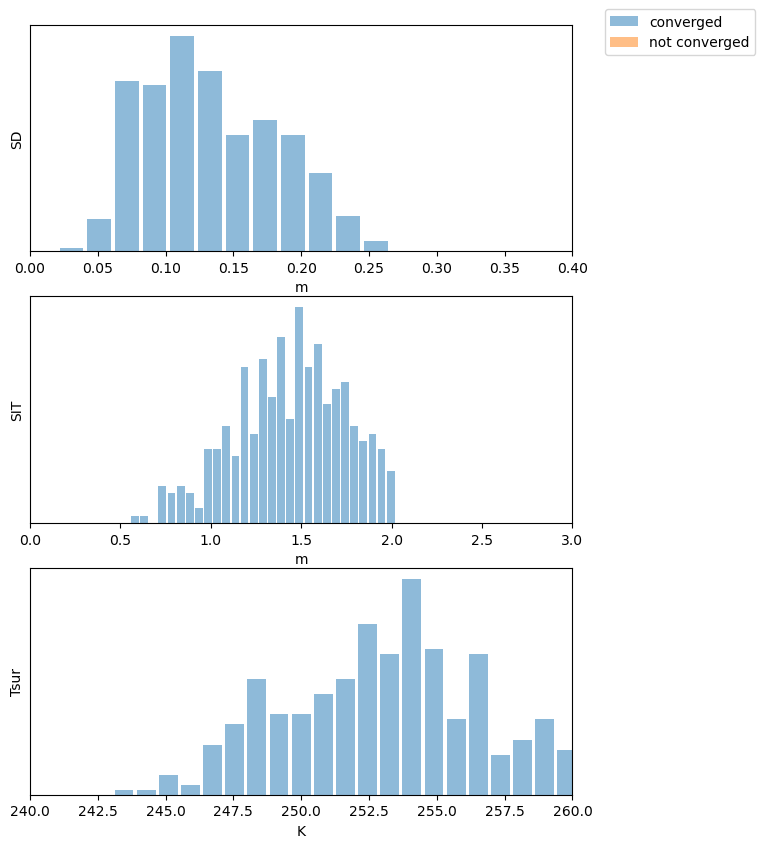

In [98]:
nn  = np.array(nn, dtype=int)
no  = np.array(no, dtype=int)

fig, ax = plt.subplots(3, figsize=(7,10), sharex=False)

vars = ['SD', 'SIT', 'Tsur']
xlabel = ['m', 'm','K']
xlim = [[0,0.4], [0,3], [240, 260]]
binss = [np.linspace(0, 1, 50), np.linspace(0, 5, 100), np.linspace(230, 270, 50)]
# bins = 
for var, i in zip([np.sum(FYI_data.sd, axis=1), FYI_data.sit, FYI_data.skt], range(3)):
    bins = binss[i]
    ax[i].hist(var[nn], bins=bins, rwidth=0.85, alpha=0.5, label = 'converged')
    ax[i].hist(var[no], bins=bins, rwidth=0.85, alpha=0.5, label='not converged')
    ax[i].set_yticks([])
    ax[i].set_ylabel(str(vars[i]))
    ax[i].set_xlabel(xlabel[i])
    ax[i].set_xlim(xlim[i])
plt.legend(bbox_to_anchor=(1.35, 3.5))

['SD', 'SIT']
Root Mean Square Error:
0.019225219341260518
[  2   5  10  12  13  17  19  20  21  22  24  25  26  27  35  36  41  57
  58  63  65  72  73  82  95  98  99 101 106 107 112 114 117 118 119 121
 123 125 127 128 129 130 131 132 133 134 135 136 137 148 149 153 155 156
 157 158 159 164 167 172 173 181 183 184 189 194 196 197 204 205 207 209
 210 215 218 221 222 223 224 228 235 236 238 239 242 243 244 245 246 247
 250 256 257 261 262 265 266 267 268 269 271 273 279 287 297 306 309 312
 316 317 320 321 329 337 340 341 342]
Root Mean Square Error:
0.019225219341260518


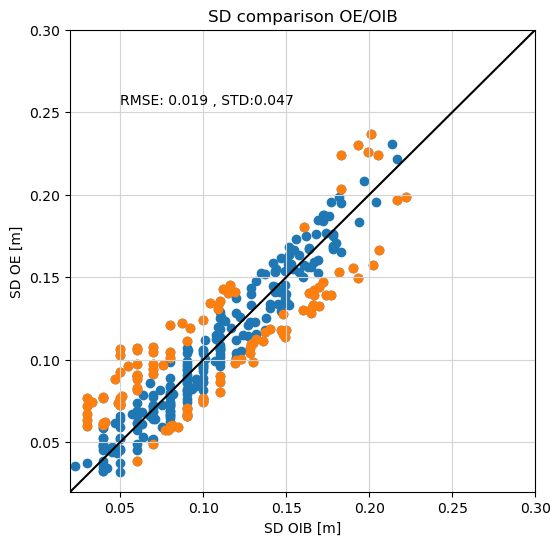

Root Mean Square Error:
0.22487724051255534


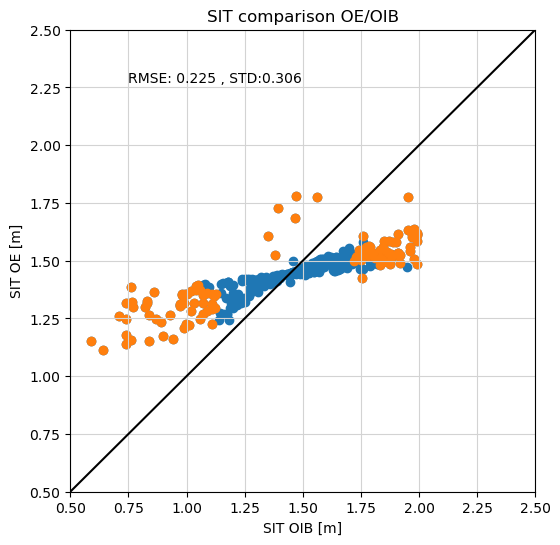

In [99]:
savepath = "C:/Users/Ida Olsen/Documents/Speciale_2022/figures/reference_results/sy_tests/"
def plot_idv(variables, OIB_data, nn):

   
    for var, data in zip(variables, OIB_data): 
        OE = []
        OIB = []
        #set limits
        for x_optim, n in zip(x_optimals, nn):
            try:
                if var=='SD' or var=='sal' or var=='lex':
                    # convert from log to linear units
                    OE.append(x_optim[var])
                else:
                    OE.append(x_optim[var])
                OIB.append(data[n])
            except:
                pass
                # print('convergence was not reached at: ', x_optim)
        
        if var=='SD' or var=='lex':
            OIB = np.array(OIB)[:,0]
        elif var=='rho' or var=='sal':
            OIB = np.array(OIB)[:,1]
        
        #print(np.shape(OIB))
        #print(np.shape(OE))
        if var=='SD':
            xlim = [0.02, 0.3]
            x = 0.05
            y = 0.255
            unit = ' [m]'
        elif var=='sal':
            xlim = [0.5, 2.0]
            unit = ' [PSU]'
            OIB = OIB*1e3
            x = 0.8
            y = 1.9
            OE = np.array(OE)*1e3
        elif var=='lex':
            xlim = [0.15, 0.3]
            unit = ' [mm]'
            x = 0.18
            y = 0.28
            OIB = OIB*1e3
            OE = np.array(OE)*1e3
        elif var=='Tsur':
            print(OIB)
            print(OE)
            xlim = [250, 265]
            x = 250
            y = 250
            unit = ' [K]'
        elif var=='SIT':
            xlim = [0.5, 2.5]
            x = 0.75
            y = 2.27
            unit = ' [m]'
        
        diag = np.linspace(0,400,400)
        
        if var=='SD' or var=='SIT':
            if var=='SD':
                BD = np.where(abs(OIB-OE)>(RMSE(OIB, OE)))[0]
                print(BD)
            
            plt.figure(figsize=(6,6))
            plt.scatter(OIB, OE)
            plt.scatter(np.array(OIB)[BD.astype(int)], np.array(OE)[BD.astype(int)], label='Diff>RMSE')
            plt.plot(diag, diag, 'k')
            plt.grid(color='lightgrey')
            plt.title(var + ' comparison OE/OIB')
            plt.xlabel(var + ' OIB' + unit)
            plt.ylabel(var + ' OE' + unit)
            plt.xlim(xlim)
            # square plot
            plt.ylim(xlim)
            # RMSE(OIB, OE)
            #MAE(OIB, OE)
            plt.text(x, y, 'RMSE: ' + str(np.round(RMSE(OIB, OE),3)) + ' , STD:' + str(np.round(np.std(OIB),3)))
            plt.savefig(savepath + var + '02_std_idv_V_test.png' )
            plt.show()



# take nn of each
OIB_data = []
print(input_variables)
if 'SD' in input_variables:
    OIB_data.append(FYI_data.sd)
if 'lex' in input_variables:
    OIB_data.append(FYI_data.sd_lex)
if 'sal' in input_variables:
    OIB_data.append(FYI_data.sd_sal)
if 'rho' in input_variables:
    OIB_data.append(FYI_data.sd_rho)
if 'Tsur' in input_variables:
    OIB_data.append(FYI_data.skt)
if 'SIT' in input_variables:
    OIB_data.append(FYI_data.sit)
plot_idv(input_variables, OIB_data, nn)

['SD', 'SIT']


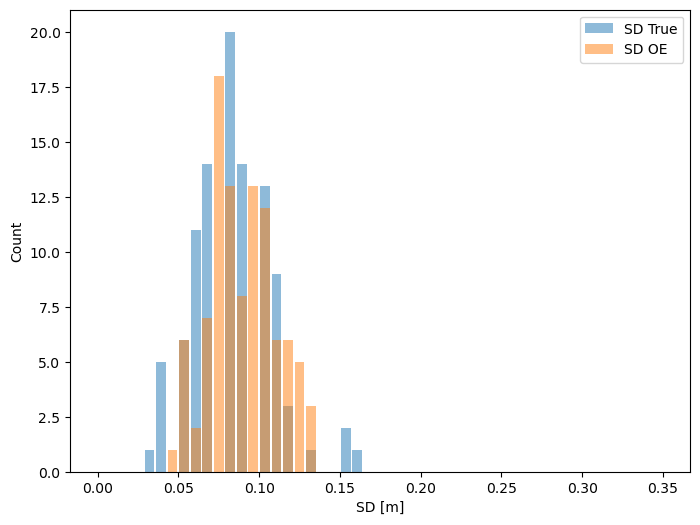

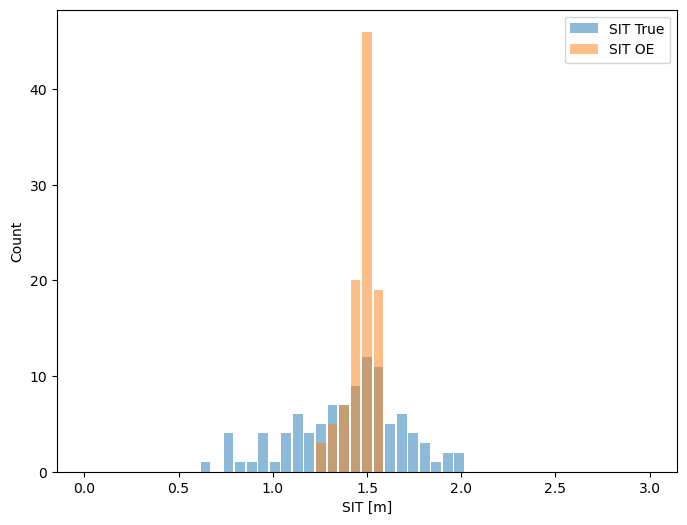

In [27]:
def hist_idv(variables, OIB_data, nn):

   
    for var, data in zip(variables, OIB_data): 
        OE = []
        OIB = []
        #set limits
        try:
            for x_optim, n in zip(x_optimals, nn):
                    OE.append(x_optim[var])
                    OIB.append(data[n])
        except:
            pass
            # print('convergence was not reached at: ', x_optim)
        
        if var=='SD' or var=='lex':
            OIB = np.array(OIB)[:,0]
        elif var=='rho' or var=='sal':
            OIB = np.array(OIB)[:,1]
        
        if var=='SD':
            bins = np.linspace(0, 0.35, 50)
            unit = ' [m]'
        elif var=='sal':
            OE = np.array(OE)*1e3
            OIB = np.array(OIB)*1e3
            bins = np.linspace(5, 15, 50)
            unit = ' [PSU]'
        elif var=='rho':
            bins = np.linspace(320, 370, 50)
            unit = ' [kg/m3]'
        elif var=='lex':
            OE = np.array(OE)*1e3
            OIB = np.array(OIB)*1e3
            bins = np.linspace(0.1, 0.2, 50)
            unit = ' [mm]'
        elif var=='Tsur':
            unit = ' [K]'
        elif var=='SIT':
            bins = np.linspace(0, 3, 50)
            unit = ' [m]'
        elif var=='slope':
            bins = np.linspace(0, 0.25, 50)
            unit = ' '
        plt.figure(figsize=(8,6))
        plt.hist(OIB, bins=bins,alpha=0.5,rwidth=0.85, label = var + ' True')
        plt.hist(OE, bins=bins, alpha=0.5,rwidth=0.85, label = var + ' OE')
        plt.legend(loc='upper right')
        plt.xlabel(var + unit)
        # plt.grid()
        plt.ylabel('Count')
        # plt.savefig(savepath + var + '_hist_idv_ref_V_know_SIT.png',bbox_inches='tight')
        plt.show()




# take nn of each
OIB_data = []
print(input_variables)
if 'SD' in input_variables:
    OIB_data.append(FYI_data.sd)
if 'lex' in input_variables:
    OIB_data.append(FYI_data.sd_lex)
if 'sal' in input_variables:
    OIB_data.append(FYI_data.sd_sal)
if 'rho' in input_variables:
    OIB_data.append(FYI_data.sd_rho)
if 'SIT' in input_variables:
    OIB_data.append(FYI_data.sit)
if 'slope' in input_variables:
    OIB_data.append(np.array([0.08 for s in FYI_data.sit]))
hist_idv(input_variables, OIB_data, nn)

In [ ]:
savepath

In [ ]:
savepath = "C:/Users/Ida Olsen/Documents/Speciale_2022/figures/reference_results/"

In [14]:
np.mean(FYI_data.sit)

1.4398281690140846

In [ ]:
for 

covOutMat(oe.S_op, oe_show.S_a)